In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from PIL import Image

# Damped Harmonic Oscillator - the inverse problem
### Karen, Andreas and Clara

Often in industrial applications of PINNs, the parameters of the governing PDEs are unknown. This is also known as **the inverse problem**. Within the framework of PINN, inverse problems are solved by expanding the PINN to also estimate the PDE-parameters. In practice, we add the PDE-parameters to the list of parameters to be optimized. 

To accommodate that the underlying PDE-parameters can be quite large, we estimate not the parameters directly but how much they differ from a "best first guess". Say we estimate $\mu$ and a aposteori guess that $\mu=\bar{\mu}$, then we estimate $d_{\mu}$, such that the estimated parameter $\hat{\mu}$ is given by
$$
\hat{\mu} = \bar{\mu} + d_{\mu} \ .
$$

The ODE, boundary and initial conditions and loss terms are as in the Damped Harmonic Oscillator PINN notebook, except the fact that we vary $\delta$ and $\omega_0$ and sample new training point for each set of ODE-parameters. 

## Training a PINN
Again we have chosen to start training a PINN with a fully connected neural network which has 4 hidden layers and 64 neurons in each of the hidden layers with $\mathrm{tanh}$ as activation function.

### Sources
This notebook is inspired by https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb and
https://github.com/benmoseley/DLSC-2023/blob/main/lecture-5/PINN%20demo.ipynb and https://towardsdatascience.com/inverse-physics-informed-neural-net-3b636efeb37e

### Analytical solution

In [2]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
# deltas = [2, 4, 8]
# omegas = [20, np.sqrt(800), 40]
deltas = [2]
omegas = [20]

x_train = []
y_train = []
par_train = []

for d in deltas:
    for w0 in omegas:

        # get the analytical solution over the full domain
        x = torch.linspace(0,1,500).view(-1,1)
        y = oscillator(d, w0, x).view(-1,1)
        # print(x.shape, y.shape)

        # slice out a small number of points from the LHS of the domain
        x_data = x[0:200:5]
        y_data = y[0:200:5]
        # print(x_data.shape, y_data.shape)

        # append training data
        x_train.append(x_data.flatten())
        y_train.append(y_data.flatten())
        par_train.append(torch.Tensor([d, w0]))

        # plt.figure()
        # plt.title(f'$\delta$ = {d}, $\omega_0$ = {np.round(w0,3)}')
        # plt.plot(x, y, color="tab:orange", label="Exact solution")
        # plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
        # plt.legend()
        # plt.show()

# convert lists to tensors-arrays
x_train = torch.stack(x_train)
y_train = torch.stack(y_train)
par_train = torch.stack(par_train)
# print(x_train.shape, y_train.shape, par_train.shape)


In [4]:
# define network architecture

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )
    
    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x


In [5]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

m = 1, mu = 4.0, omega = 20.0


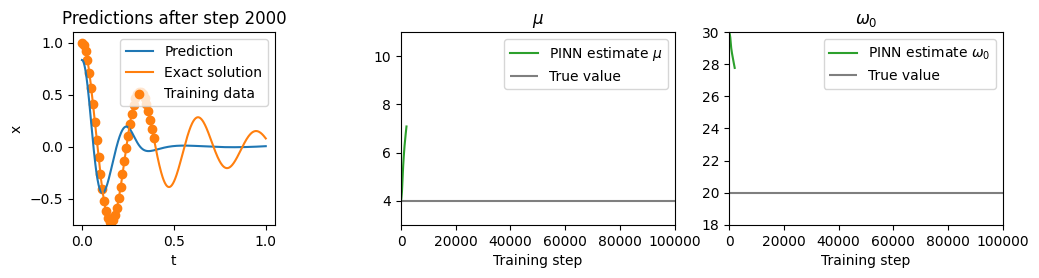

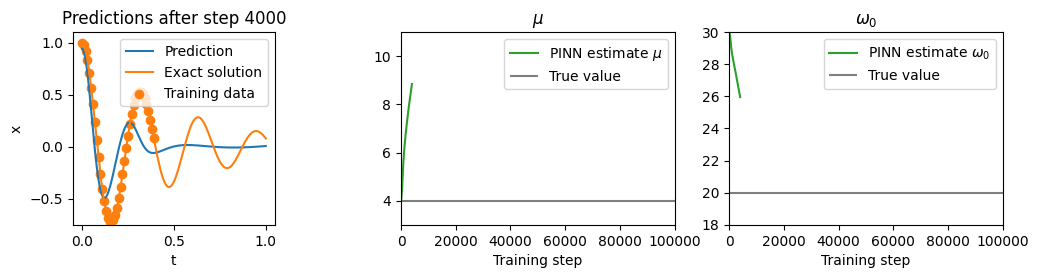

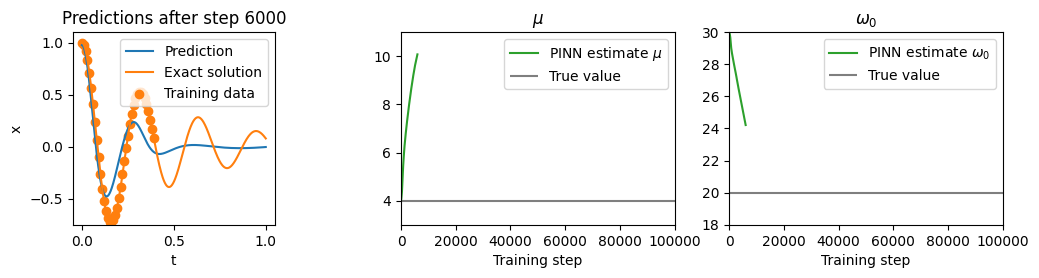

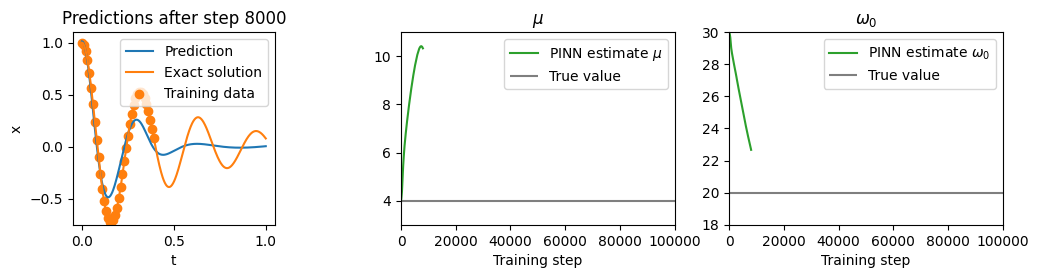

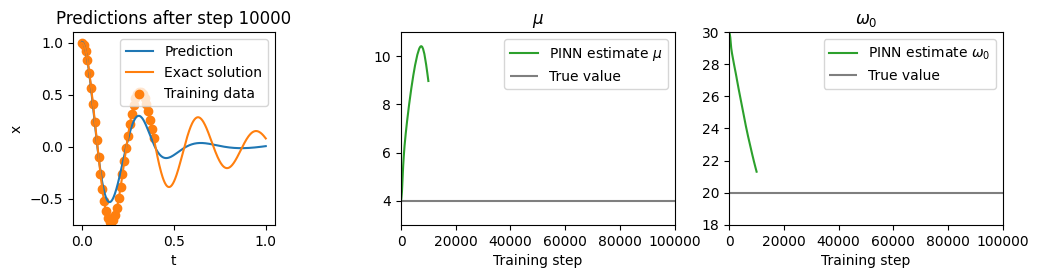

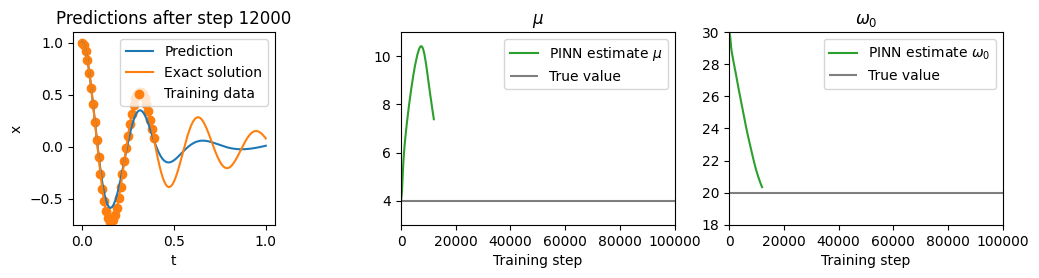

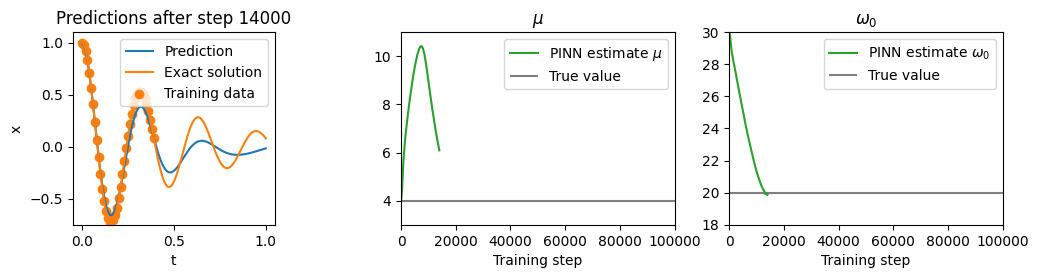

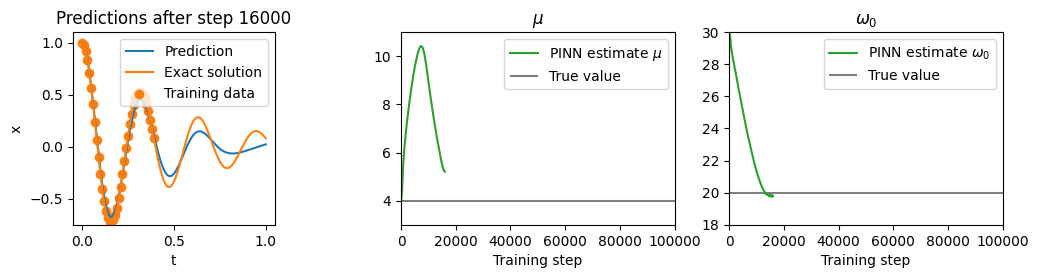

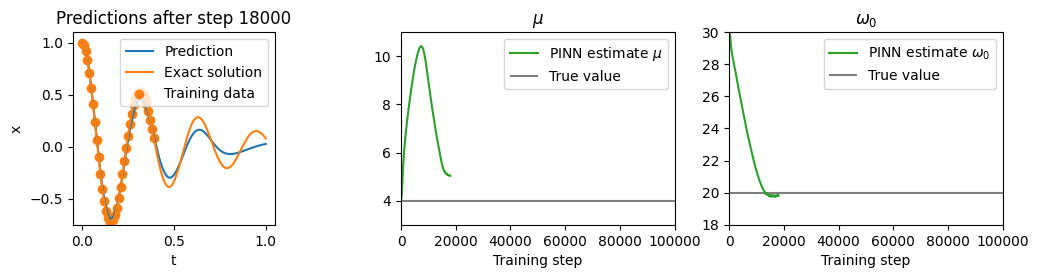

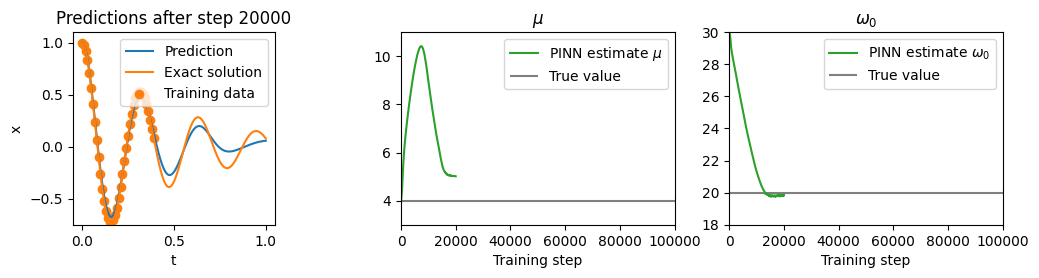

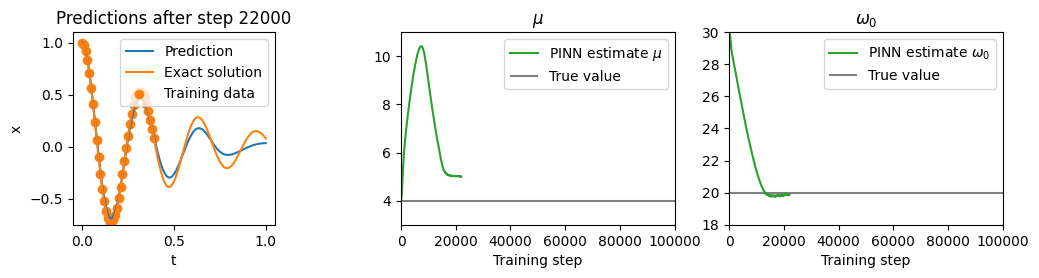

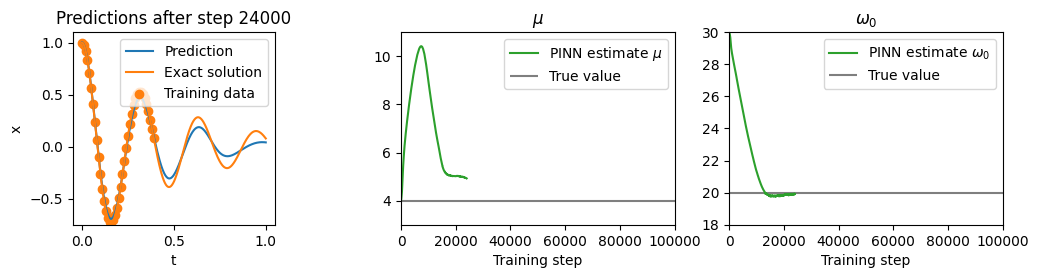

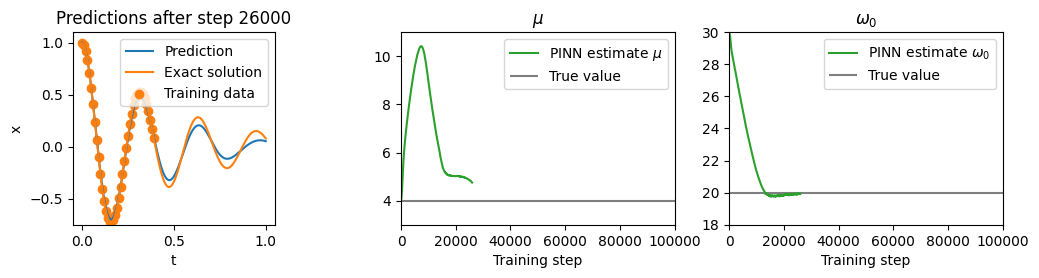

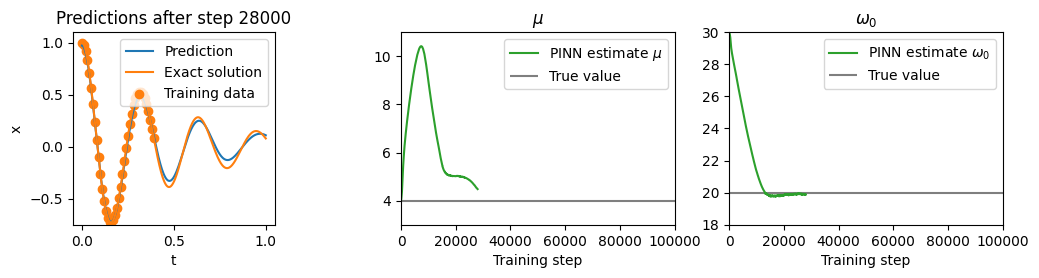

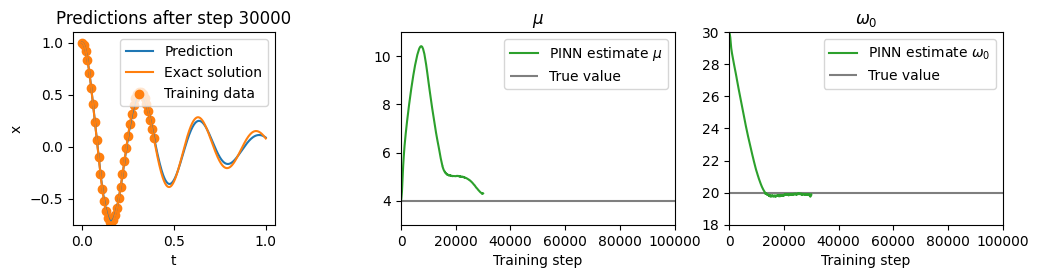

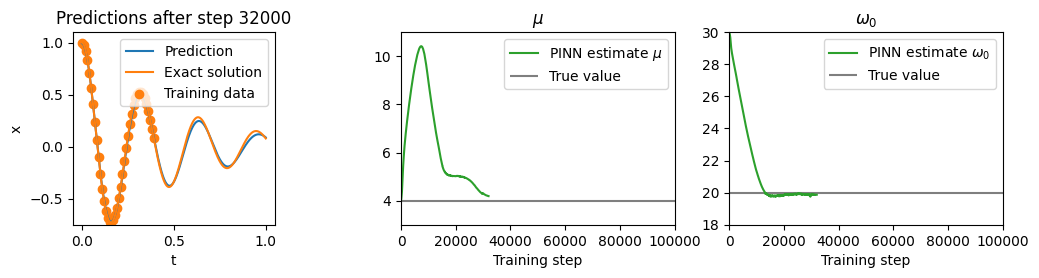

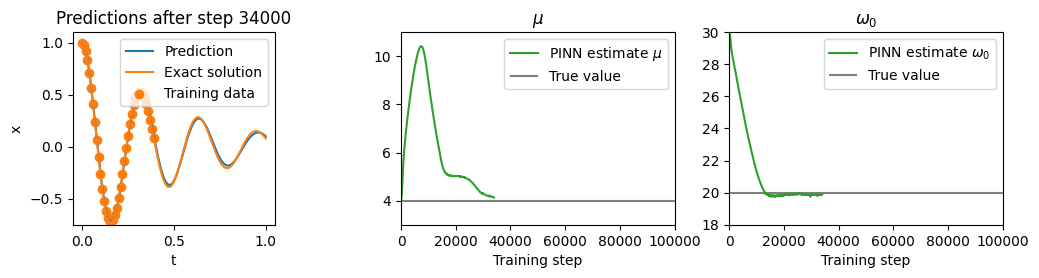

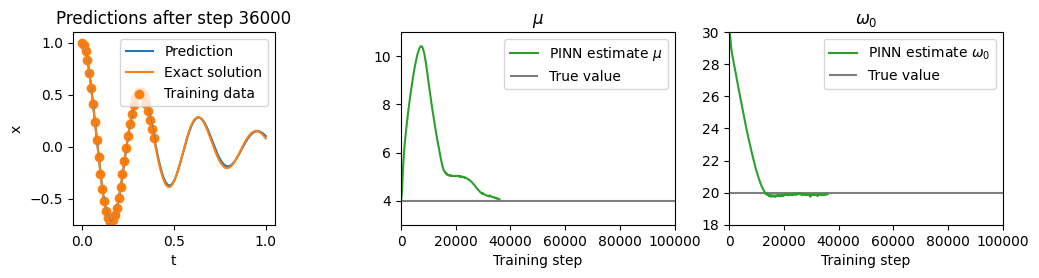

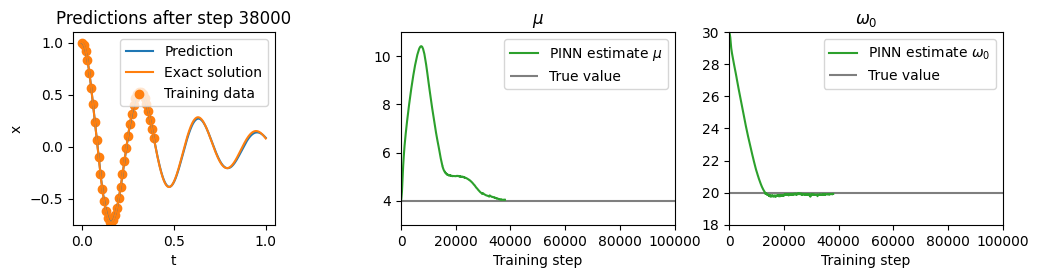

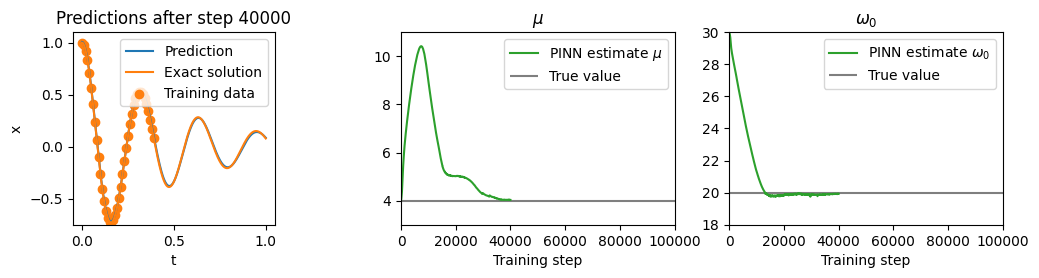

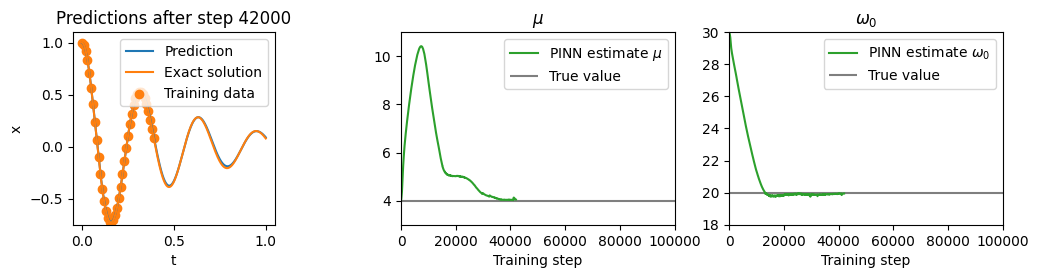

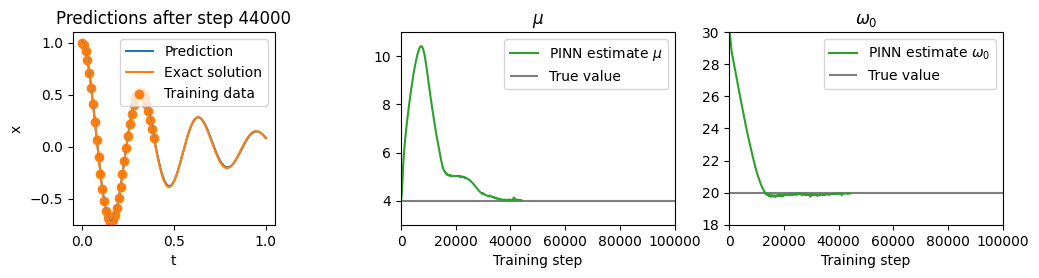

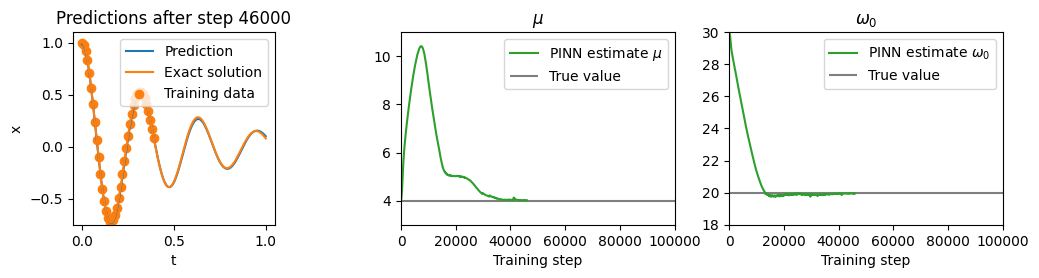

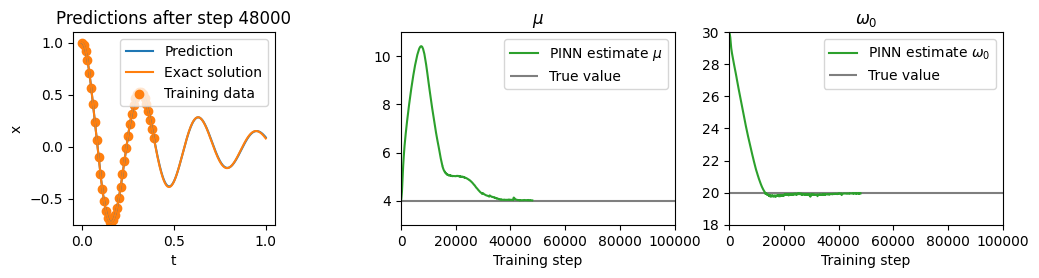

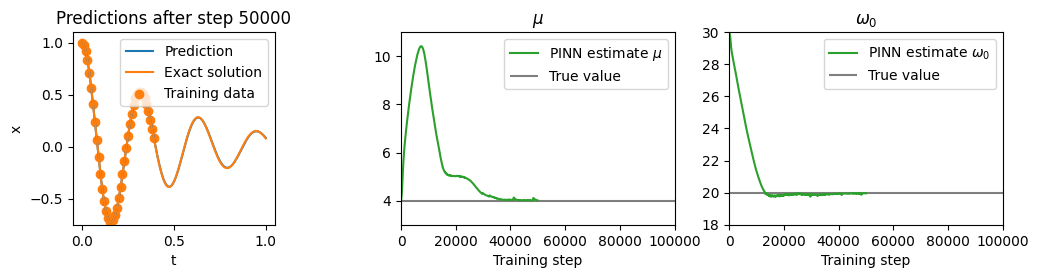

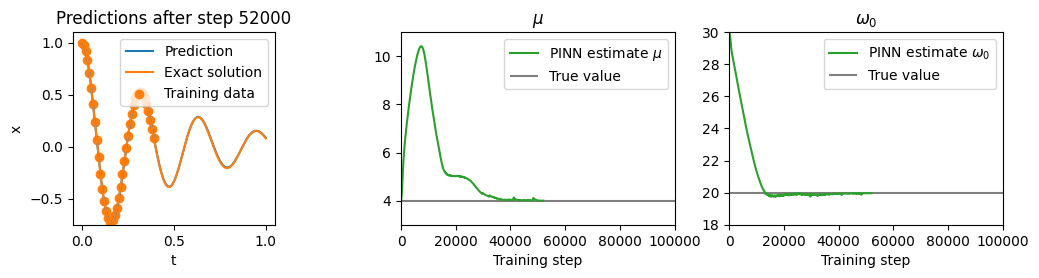

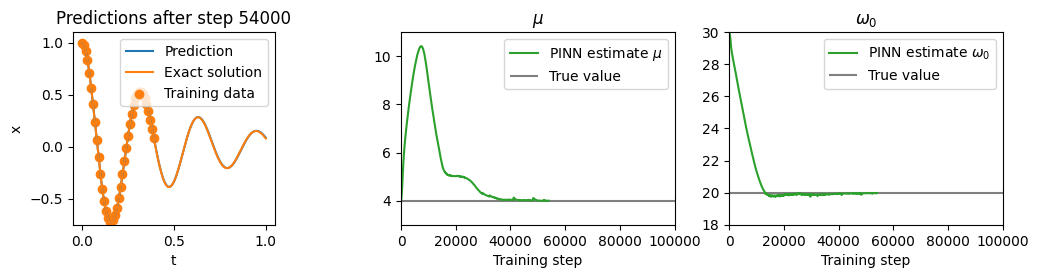

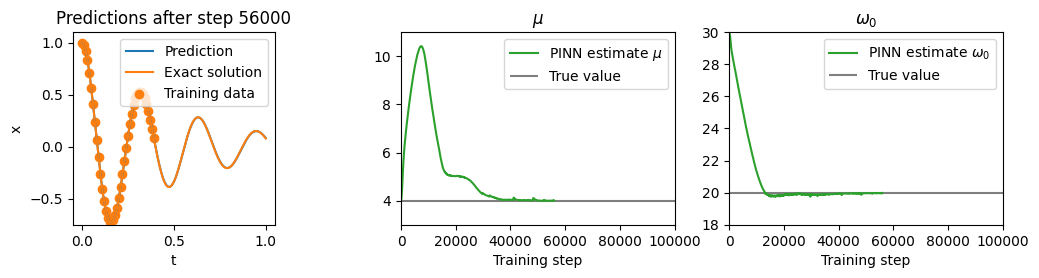

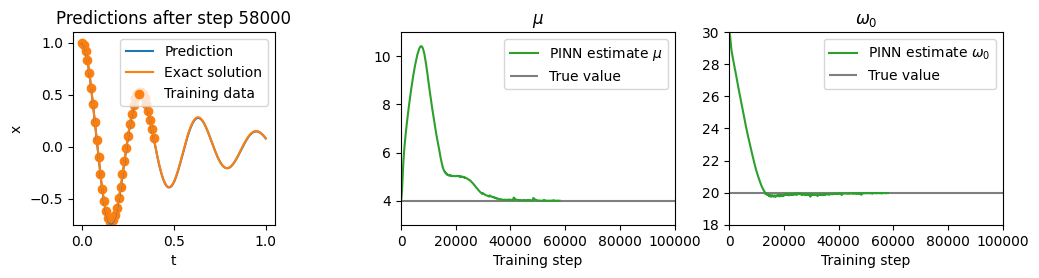

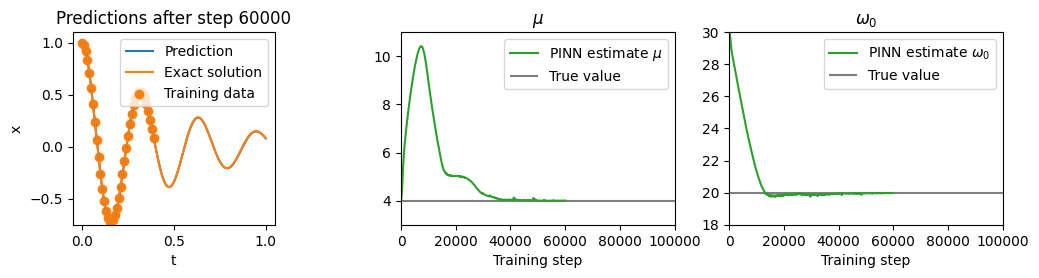

In [7]:
physics_xs = torch.linspace(0, 1, 40).view(-1, 1).requires_grad_(True)

m_value = 1

for i, [d, w0] in enumerate(par_train):
  print(f'm = {m_value}, mu = {d*2}, omega = {w0}')
    
  data_x = x_train[i]
  data_x = data_x[:, None]
  data_y = y_train[i]
  data_y = data_y[:, None]

  # mu, k = 2*d, w0**2
  # mu = 2*d
  # k = w0 ** 2
  d_mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True)) # initialize d_mu with value 0
  mu_bar = torch.nn.Parameter(torch.ones(1, requires_grad=True)*4) # initialize mu_bar with value 4
  d_omega = torch.nn.Parameter(torch.zeros(1, requires_grad=True)) # initialize d_omega with value 0
  omega_bar = torch.nn.Parameter(torch.ones(1, requires_grad=True)*30) # initialize mu_bar with value 30

  torch.manual_seed(123)
  model = FullyConnected(1, 64, 1)
  optimizer2 = torch.optim.Adam(list(model.parameters())+ [d_mu] + [d_omega], lr=1e-3)#, weight_decay=1e-4)
  scheduler = StepLR(optimizer2, step_size=10000, gamma=0.9)

  files = []
  mus = []
  ws = []
  for i in range(60001):
    optimizer2.zero_grad()

    # data loss
    pred_y = model(data_x)
    data_loss = torch.mean((pred_y - data_y) ** 2) # Mean squared error

    # physics loss
    physics_pred_y = model(physics_xs)
    dx = torch.autograd.grad(physics_pred_y, physics_xs, torch.ones_like(physics_pred_y), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx, physics_xs, torch.ones_like(dx), create_graph=True)[0]
    residual = dx2 + (mu_bar + d_mu) * dx + ((omega_bar + d_omega) ** 2) * physics_pred_y
    physics_loss = torch.mean(residual**2)

    # boundary conditions loss
    t_boundary = torch.zeros(1, requires_grad=True) # torch.tensor([0])
    x_boundary = torch.ones(1, requires_grad=True) #torch.tensor([1])
    # dx_boundary = torch.zeros(1, requires_grad=True) #torch.tensor([0])
    x0_predicted = model(t_boundary)
    dx_predicted = torch.autograd.grad(x0_predicted, t_boundary, torch.ones_like(t_boundary), create_graph=True)[0]
    residual_x0 = x0_predicted - x_boundary
    residual_dx = dx_predicted
    boundary_loss = torch.mean(residual_x0 ** 2) 
    initial_loss = torch.mean(residual_dx ** 2)

    loss = (1e-4) * physics_loss + data_loss + boundary_loss + initial_loss
    loss.backward()
    optimizer2.step()
    scheduler.step()

    # record parameter values
    mus.append(mu_bar.item() + d_mu.item())
    ws.append(omega_bar.item() + d_omega.item())

    if i % 2000 == 0 and i != 0:
      detached_t = physics_xs.detach()

      # get the analytical and predicted solution over the full domain
      x = torch.linspace(0,1,500).view(-1,1)
      y = oscillator(d, w0, x).view(-1,1)
      pred_ys = model(x).detach()

      plt.figure(figsize=(12,2.5))

      plt.subplot(1,4,1)
      plt.plot(x, pred_ys, color="tab:blue", label="Prediction")
      plt.plot(x, y, color="tab:orange", label="Exact solution")
      # plt.scatter(detached_t, torch.zeros_like(detached_t))
      plt.scatter(data_x, data_y, color="tab:orange", label="Training data")
      plt.title(f'Predictions after step {i}')
      plt.ylim(-0.75, 1.1)
      plt.xlabel('t')
      plt.ylabel('x')
      plt.legend()

      plt.subplot(1,3,2)
      plt.title("$\mu$")
      plt.plot(mus, label="PINN estimate $\mu$", color="tab:green")
      plt.hlines(2*d, 0, 100004, label="True value", color="tab:grey")
      plt.xlabel("Training step")
      plt.xlim(0, 100005)
      plt.ylim(3, 11)
      plt.legend()

      plt.subplot(1,3,3)
      plt.title("$\omega_0$")
      plt.plot(ws, label="PINN estimate $\omega_0$", color="tab:green")
      plt.hlines(w0 , 0, 100004, label="True value", color="tab:grey")
      plt.xlabel("Training step")
      plt.xlim(0, 100005)
      plt.ylim(18, 30)
      plt.legend()

      file = "plots/ipinn_%.8i.png"%(i)
      plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
      files.append(file)
      
      plt.show()

  save_gif_PIL(f'DHO_ipinn_{d}_{np.round(w0,2)}.gif', files, fps=20, loop=0)